In [5]:
import sys
sys.path.append("./../..")
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit
from tqdm import tqdm
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.analysis import pairplot
import torch
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [6]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [7]:
num_rounds = 2
num_dim = 3
# The specific observation we want to focus the inference on.
x_o = torch.zeros(num_dim,)
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(linear_gaussian, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [8]:
inference = SNPE(prior=prior)

In [9]:
posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 69 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

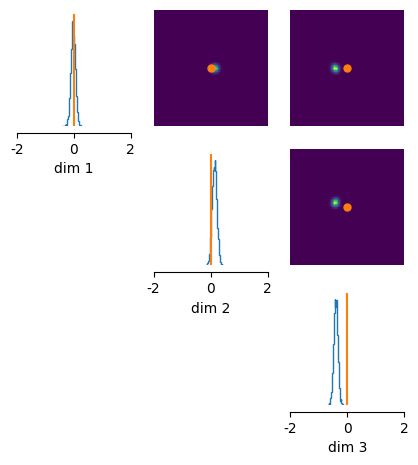

In [19]:
posterior_samples = posterior.sample((10000,), x=linear_gaussian(x_o))

# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5), points=x_o
)